# Accurate Integer Mathematics in Transformers - Analyse the Model

This CoLab analyses a Transformer model that performs integer addition, subtraction and multiplication e.g. 133357+182243=+0315600, 123450-345670=-0123230 and 000345*000823=+283935. Each digit is a separate token. For 6 digit questions, the model is given 14 "question" (input) tokens, and must then predict the corresponding 8 "answer" (output) tokens.

The model weightings created by the sister CoLab [Accurate_Math_Train](https://github.com/PhilipQuirke/transformer-maths/blob/main/assets/Accurate_Math_Train.ipynb) are loaded from Google Drive.

## Tips for using the Colab
 * You can run and alter the code in this CoLab notebook yourself in Google CoLab ( https://colab.research.google.com/ ).
 * To run the notebook, in Google CoLab, **you will need to** go to Runtime > Change Runtime Type and select GPU as the hardware accelerator.
 * Some graphs are interactive!
 * Use the table of contents pane in the sidebar to navigate.
 * Collapse irrelevant sections with the dropdown arrows.
 * Search the page using the search in the sidebar, not CTRL+F.

# Part 1: Configuration


In [ ]:
# Tokens used in vocab. (Token indexes 0 to 9 represent digits 0 to 9)
PLUS_INDEX = 10
MINUS_INDEX = 11
EQUALS_INDEX = 12

class Config():
  #@markdown Model
  n_layers: int = 2 #@param
  n_heads: int = 3 #@param

  d_vocab: int = EQUALS_INDEX+1
  d_model: int = ( 512 // n_heads ) * n_heads # About 512, and divisible by n_heads
  d_mlp: int = 4 * d_model
  d_head: int = d_model // n_heads  # About 170 when n_heads == 3
  seed: int = 129000 #@param

  #@markdown Data
  n_digits: int = 5 #@param
  n_ctx: int = 3 * n_digits + 3
  act_fn: str = 'relu'
  batch_size: int = 64 #@param

  #@markdown Optimizer
  n_training_steps: int = 30000 #@param
  lr: float = 0.00008 #@param
  weight_decay: int = 0.1 #@param

  # Save graphs to CoLab temp files as PDF and HTML. Can manually export files for re-use in papers.
  save_graph_to_file: bool = True

  # The format to output prettytable in. Options are text|html|json|csv|latex
  # Use Text for this CoLab, latex for Overleaf output, and html for GitHub blog output
  table_out_format: str = "text"


cfg = Config()

# Part 2: Import libraries
Imports standard libraries. Don't bother reading.
You will need to give permission for this CoLab to access your Google Drive to load the model weights (created by the "Accurate Addition - Train" CoLab.

In [ ]:
from google.colab import drive
from pathlib import Path

In [ ]:
GLOBAL=True
if GLOBAL:
    drive.mount('/content/drive', force_remount=False)
    rootdir=Path('/content/drive/MyDrive/AI/CoLabOutput/')
else:
    rootdir=Path('./')

base_fname = '_digits{}_layer{}_heads{}_dmodel{}_dhead{}_ctx{}_seed{}_train{}.pt'.format(cfg.n_digits, cfg.n_layers, cfg.n_heads, cfg.d_model, cfg.d_head, cfg.n_ctx, cfg.seed, cfg.n_training_steps)

add_fname = 'add' + base_fname
model_save_location = rootdir/f'{add_fname}'

print(f'rootdir is {rootdir}')
print('model will save to {}'.format(str(model_save_location)))

Mounted at /content/drive
rootdir is /content/drive/MyDrive/AI/CoLabOutput
model will save to /content/drive/MyDrive/AI/CoLabOutput/add_digits5_layer2_heads3_dmodel510_dhead170_ctx18_seed129000_train30000.pt


In [ ]:
DEVELOPMENT_MODE = True
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")

    %pip install --upgrade numpy
    %pip install matplotlib
    %pip install prettytable
    %pip install seaborn

    %pip install kaleido
    %pip install transformer_lens
    %pip install torchtyping
    %pip install transformers

except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Colab notebook
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 44.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires python-mu

In [ ]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import kaleido
import plotly.io as pio

if IN_COLAB or not DEVELOPMENT_MODE:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

import plotly.express as px
import plotly.graph_objects as go

Using renderer: colab


In [ ]:
pio.templates['plotly'].layout.xaxis.title.font.size = 20
pio.templates['plotly'].layout.yaxis.title.font.size = 20
pio.templates['plotly'].layout.title.font.size = 30

In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import tqdm.auto as tqdm
import random
from prettytable import PrettyTable
import matplotlib.pyplot as plt

In [ ]:
# Use seaborn library to display heatmaps
use_sns= True
try:
  import seaborn as sns
except Exception as e:
  # Suggested work around for conflicts between multiple packages importing different numpy versions
  !pip install numpy==1.24.1
  try:
    import seaborn as sns
  except Exception as e:
    print("sns import exception", e)
    use_sns = False

# Use Principal Component Analysis (PCA) library
use_pca = True
try:
  from sklearn.decomposition import PCA
except Exception as e:
  print("pca import exception", e)
  use_pca = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 27.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.2
    Uninstalling numpy-1.26.2:
      Successfully uninstalled numpy-1.26.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 2.1.2 which is incompatible.
torchvision 0.16.0+cu121 requires torch==2.1.0, but you have torch 2.1.2 which is incompatible.


sns import exception module 'numpy' has no attribute '_no_nep50_warning'
pca import exception module 'numpy' has no attribute '_no_nep50_warning'


In [ ]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache


# Part 3: Create model
This section defines the token embedding / unembedding and creates the model.

In [ ]:
# Embedding / Unembedding

def tokens_to_string(tokens):
    tokens = utils.to_numpy(tokens)
    x = "".join([str(i) for i in tokens[:cfg.n_digits]])
    y = "".join([str(i) for i in tokens[cfg.n_digits+1:cfg.n_digits*2+1]])
    z = "".join([str(i) for i in tokens[cfg.n_ctx-cfg.n_digits-1:]])
    equals = "="
    operator = "+"
    return f"{x}{operator}{y}{equals}{z}"

def string_to_tokens(string, batch: bool=False):
    lookup = {str(i):i for i in range(10)}
    lookup['+']=PLUS_INDEX
    lookup['-']=MINUS_INDEX
    lookup['=']=EQUALS_INDEX

    tokens = [lookup[i] for i in string if i not in '\n ']
    if batch:
        return torch.tensor(tokens)[None, :]
    else:
        return torch.tensor(tokens)

In [ ]:
# Transformer creation

# Structure is documented at https://neelnanda-io.github.io/TransformerLens/transformer_lens.html#transformer_lens.HookedTransformerConfig.HookedTransformerConfig
ht_cfg = HookedTransformerConfig(
    n_layers = cfg.n_layers,
    n_heads = cfg.n_heads,
    d_model = cfg.d_model,
    d_head = cfg.d_head,
    d_mlp = cfg.d_mlp,
    act_fn = cfg.act_fn,
    normalization_type = 'LN',
    d_vocab = cfg.d_vocab,
    d_vocab_out = cfg.d_vocab,
    n_ctx = cfg.n_ctx,
    init_weights = True,
    device = "cuda",
    seed = cfg.seed,
)

model = HookedTransformer(ht_cfg)

optimizer = optim.AdamW(model.parameters(),
                        lr = cfg.lr,
                        weight_decay = cfg.weight_decay,
                        betas = (0.9, 0.98))

# Gives 2e-9 loss (but changes the cells used by the model)
# max_iter = cfg.n_training_steps
# warmup_iter = max_iter // 5
# scheduler1 = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.01, total_iters=int(warmup_iter))
# scheduler2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(np.ceil((max_iter-warmup_iter))))
# scheduler  = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[int(warmup_iter)])

# Gives 3e-8 loss
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda step: min(step/10, 1))

# Part 4: Data Generator. Addition sub-task categorisation
This section defines the loss function and the training/tesing data generator.

It also defines functions to categorise the training data by the addition sub-task defined in the paper. The addition sub tasks are abbreviated as:
- BA is Base Add. Calculates the sum of two digits Dn and Dn' modulo 10, ignoring any carry over from previous columns.
- MC1 is Make Carry 1. Evaluates to true if adding digits Dn and Dn' results in a carry over of 1 to the next column.
- MS9 is Make Sum 9. Evaluates to true if adding digits Dn and Dn' gives exactly 9.
- UC1 is Use Carry 1. Takes the previous column's carry output and adds it to the sum of the current digit pair.
- US9 is Use Sum 9. Propagates (aka cascades) a carry over of 1 to the next column if the current column sums to 9 and the previous column generated a carry over. US9 is the most complex task as it spans three digits. For some rare questions (e.g. 00555 + 00445 = 01000) US9 applies to up to four sequential digits, causing a chain effect, with the MC1 cascading through multiple digits.

In [ ]:
# Loss functions

# Calculate the per-token probability by comparing a batch of prediction "logits" to answer "tokens"
def logits_to_tokens_loss(logits, tokens):

  # The last "n_digit+1" tokens are the addition answer probabilities
  ans_logits = logits[:, -(cfg.n_digits+2):-1]

  # Convert raw score (logits) vector into a probability distribution.
  # Emphasize the largest scores and suppress the smaller ones, to make them more distinguishable.
  ans_probs = F.log_softmax(ans_logits.to(torch.float64), dim=-1)

  max_indices = torch.argmax(ans_probs, dim=-1)

  # The last "n_digit+1" tokens are the model’s answer.
  ans_tokens = tokens[:, -(cfg.n_digits+1):]

  # Extract values from the ans_probs tensor, based on indices from the ans_tokens tensor
  ans_loss = torch.gather(ans_probs, -1, ans_tokens[:, :, None])[..., 0]

  return ans_loss, max_indices

# Calculate loss as negative of average per-token mean probability
def loss_fn(ans_loss):
  return -ans_loss.mean(0)

In [ ]:
# Define "iterator" data generator function. Invoked using next().
# "Addition" batch entries are formated XXXXX+YYYYY=ZZZZZZ e.g. 55003+80002=135005
# "Subtraction" batch entries are formated XXXXX-YYYYY=ZZZZZZ e.g. 55003-80002=-24999, 80002-55003=024999
# Note that answer has one more digit than the question
# Returns characteristics of each batch entry to aid later analysis
def data_generator():
    torch.manual_seed(cfg.seed)
    while True:
        #generate a batch of questions (answers calculated below)
        batch = torch.zeros((cfg.batch_size, cfg.n_ctx)).to(torch.int64)
        x = torch.randint(0, 10, (cfg.batch_size, cfg.n_digits))
        y = torch.randint(0, 10, (cfg.batch_size, cfg.n_digits))


        # The UseSum9 task is compound and rare and so hard to learn.
        # For some batches, we increase the MakeSum9 case frequency
        # UseSum9 also relies on MakeCarry1 (50%) from previous column.
        # So UseSum9 frequency is increased by 60% * 40% * 50% = 12%
        if random.randint(1, 5) < 3: # 60%
          # Flatten x and y to 1D tensors
          x_flat = x.view(-1)
          y_flat = y.view(-1)

          num_elements_to_modify = int(0.40 * x.numel()) # 40%
          indices_to_modify = torch.randperm(x_flat.numel())[:num_elements_to_modify]
          if random.randint(1, 2) == 1:
            x_flat[indices_to_modify] = 9 - y_flat[indices_to_modify]
          else:
            y_flat[indices_to_modify] = 9 - x_flat[indices_to_modify]

          # Reshape x and y back to its original shape
          x = x_flat.view(x.shape)
          y = y_flat.view(x.shape)


        batch[:, :cfg.n_digits] = x
        batch[:, cfg.n_digits] = PLUS_INDEX
        batch[:, 1+cfg.n_digits:1+cfg.n_digits*2] = y
        batch[:, 1+cfg.n_digits*2] = EQUALS_INDEX

        # These attributes are used for testing addition
        base_adds = torch.zeros((cfg.batch_size,cfg.n_digits)).to(torch.int64)
        make_carry1s = torch.zeros((cfg.batch_size,cfg.n_digits)).to(torch.int64)
        sum9s = torch.zeros((cfg.batch_size,cfg.n_digits)).to(torch.int64)
        use_carry1s = torch.zeros((cfg.batch_size,cfg.n_digits)).to(torch.int64)
        use_sum9s = torch.zeros((cfg.batch_size,cfg.n_digits)).to(torch.int64)

        # generate the addition question answers & other info for testing
        for i in range(cfg.n_digits):
            # the column in the test attributes being updated
            test_col = cfg.n_digits-1-i

            base_add = batch[:, cfg.n_digits-1-i] + batch[:, 2*cfg.n_digits-i]
            base_adds[:, test_col] = base_add % 10

            sum9 = (base_add == 9)
            sum9s[:, test_col] = sum9

            if i>0:
              use_carry1s[:, test_col] = make_carry1s[:, test_col+1]
            use_carry = use_carry1s[:, test_col]

            use_sum9s[:, test_col] = sum9 & use_carry;

            digit_sum = base_add + use_carry1s[:, test_col]

            make_carry = (digit_sum >= 10)
            make_carry1s[:, test_col] = make_carry

            batch[:, -1-i] = (digit_sum % 10)

        # Final (possible) carry to highest digit of the sum
        batch[:, -1-cfg.n_digits] = make_carry1s[:, 0]

        yield batch.cuda(), base_adds.cuda(), make_carry1s.cuda(), sum9s.cuda(), use_carry1s.cuda(), use_sum9s.cuda()

In [ ]:
ds = data_generator()

tokens, base_adds, make_carry1s, sum9s, use_carry1s, use_sum9s = next(ds)

print(tokens[0])

tensor([ 5,  0,  4,  4,  4, 10,  6,  4,  5,  7,  1, 12,  1,  1,  5,  0,  1,  5],
       device='cuda:0')


# Part 5 Load Model from Google Drive

In [ ]:
def print_config():
  print("n_digits=", cfg.n_digits, "n_heads=", cfg.n_heads, "n_layers=", cfg.n_layers, "n_ctx=", cfg.n_ctx, "seed=", cfg.seed, "n_training_steps=", cfg.n_training_steps)

In [ ]:
print("Loading model from file", model_save_location)
model.load_state_dict(torch.load(model_save_location))
model.eval()

Loading model from file /content/drive/MyDrive/AI/CoLabOutput/add_digits5_layer2_heads3_dmodel510_dhead170_ctx18_seed129000_train30000.pt


HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resi

# Part 8: Sample Questions Set Up

Create sets of sample questions (by task) to ask the model to predict

In [ ]:
# Insert a number into the question
def insert_question_number(the_question, index, first_digit_index, the_digits, n):

  last_digit_index = first_digit_index + the_digits - 1

  for j in range(the_digits):
    the_question[index, last_digit_index-j] = n % 10
    n = n // 10


# Create a single question
def make_a_question(the_question, index, q1, q2):
  a = q1 + q2

  insert_question_number(the_question, index, 0, cfg.n_digits, q1)

  the_question[index, cfg.n_digits] = PLUS_INDEX

  insert_question_number( the_question, index, cfg.n_digits+1, cfg.n_digits, q2)

  the_question[index, 2*cfg.n_digits+1] = EQUALS_INDEX
  offset = 2

  insert_question_number(the_question, index, 2*cfg.n_digits + offset, cfg.n_digits+1, q1+q2)


# Create a batch of questions from a 2D matrix of ints
def make_questions(q_matrix):
  length = len(q_matrix)

  questions = torch.zeros((length, cfg.n_ctx)).to(torch.int64)

  limit = 10 ** cfg.n_digits
  for i in range(length):
    if (q_matrix[i][0] < limit) and (q_matrix[i][1] < limit) :
      make_a_question(questions, i, q_matrix[i][0], q_matrix[i][1])

  return questions


def prediction_to_string(max_indices):
  answer = "".join([str(i) for i in utils.to_numpy(max_indices)[0]])
  return answer;

In [ ]:
# Analyse the question and return the use case as BA, MC, SimpleUS9 or CascadeUS9
def get_question_case(q):
  qa = utils.to_numpy(q)
  qn = qa[:2*cfg.n_digits+2]

  # Locate the MC and MS digits (if any)
  mc = torch.zeros( cfg.n_digits).to(torch.int64)
  ms = torch.zeros( cfg.n_digits).to(torch.int64)
  for dn in range(cfg.n_digits):
    if qn[dn] + qn[dn + cfg.n_digits + 1] == 9:
      ms[cfg.n_digits-1-dn] = 1
    if qn[dn] + qn[dn + cfg.n_digits +1] > 9:
      mc[cfg.n_digits-1-dn] = 1

  # Calculate the use case of a question
  if torch.sum(mc) == 0:
    return "BA"

  if torch.sum(ms) == 0:
    return "MC1"

  for dn in range(cfg.n_digits):
    if dn < cfg.n_digits-2 and mc[dn] == 1 and ms[dn+1] == 1 and ms[dn+2] == 1:
      return "CascadeUS9"

  for dn in range(cfg.n_digits):
    if dn < cfg.n_digits-1 and mc[dn] == 1 and ms[dn+1] == 1:
      return "SimpleUS9"

  return "MC1"

In [ ]:
# Manually create some questions that strongly test one use case


def make_ba_questions():
    return make_questions(
      [[12345, 33333],
      [33333, 12345],
      [45762, 33113],
      [888, 11111],
      [2362, 23123],
      [15, 81],
      [1000, 4440],
      [4440, 1000],
      [24033, 25133],
      [23533, 21133],
      [32500, 1],
      [31500, 1111],
      [5500, 12323],
      [4500, 2209],
      [ 33345, 66643], # =099988
      [ 66643, 33345], # =099988
      [10990, 44000],
      [60000, 30000],
      [10000, 20000]])


def make_uc1_questions():
    return make_questions(
      [[ 15, 45],
      [ 25, 55],
      [ 35, 59],
      [ 40035, 40049],
      [ 5025, 5059],
      [ 15, 65],
      [ 44000, 46000],
      [ 70000, 40000],
      [ 15000, 25000],
      [ 35000, 35000],
      [ 45000, 85000],
      [ 67000, 85000],
      [ 99000, 76000],
      [ 1500, 4500],
      [ 2500, 5500],
      [ 3500, 5900],
      [ 15020, 45091],
      [ 25002, 55019],
      [ 35002, 59019]])


def make_simple_us9_questions():
    return make_questions(
      [[ 55, 45],
      [ 45, 55],
      [ 45, 59],
      [ 35, 69],
      [ 25, 79],
      [ 15, 85],
      [ 15, 88],
      [ 15508, 14500],
      [ 14508, 15500],
      [ 24533, 25933],
      [ 23533, 26933],
      [ 32500, 7900],
      [ 31500, 8500],
      [ 550, 450],
      [ 450, 550],
      [ 10880, 41127],
      [ 41127, 10880],
      [ 12386, 82623]])


def make_cascade_us9_questions(clean = True):
    return make_questions(
      # These are two level UseSum9 cascades
      [[ 555, 445],
      [ 3340, 6660],
      [ 8880, 1120],
      [ 1120, 8880],
      [ 123, 877],
      [ 877, 123],
      [ 321, 679],
      [ 679, 321],
      [ 1283, 88786],
      # These are three level UseSum9 cascades
      [ 5555, 4445],
      [ 55550, 44450],
      [ 334, 666],
      [ 3340, 6660],
      [ 33400, 66600],
      [ 888, 112],
      [ 8880, 1120],
      [ 88800, 11200],
      [ 1234, 8766],
      [ 4321, 5679],
      # These are four level UseSum9 cascades
      [ 44445, 55555],
      [ 33334, 66666],
      [ 88888, 11112],
      [ 12345, 87655],
      [ 54321, 45679],
      [ 45545, 54455],
      [ 36634, 63366],
      [ 81818, 18182],
      [ 87345, 12655],
      [ 55379, 44621]])


# These questions focus mainly on 1 digit at a time
# (We're assuming that the 0 + 0 digit additions are trivial bigrams)
def make_answerdigit_questions():
    return make_questions(
      [[ 1, 0],
      [ 4, 3],
      [ 5, 5],
      [ 8, 1],
      [ 40, 30],
      [ 44, 46],
      [ 400, 300],
      [ 440, 460],
      [ 800, 100],
      [ 270, 470],
      [ 600, 300],
      [ 4000, 3000],
      [ 4400, 4600],
      [ 6000, 3000],
      [ 7000, 4000],
      [ 40000, 30000],
      [ 44000, 46000],
      [ 60000, 30000],
      [ 70000, 40000],
      [ 10000, 20000],
      [ 15000, 25000],
      [ 35000, 35000],
      [ 45000, 85000],
      [ 67000, 85000],
      [ 99000, 76000],
      [ 76000, 99000]])


# Returns 128 random and ~100 manually-chosen questions
def make_varied_questions():
  q0, _, _, _, _, _ = next(ds)
  q1 = make_ba_questions()
  q2 = make_uc1_questions()
  q3 = make_simple_us9_questions()
  q4 = make_cascade_us9_questions()
  q5 = make_answerdigit_questions()
  q6, _, _, _, _, _ = next(ds)

  questions = torch.vstack((q0.cuda(), q1.cuda(), q2.cuda(), q3.cuda(), q4.cuda(), q5.cuda(), q6.cuda()))

  return questions

In [ ]:
# Test that the get_question_case code works as expected
def unit_test_get_question_case_core(correct_case, questions):
  num_questions = questions.shape[0]
  print( correct_case, "#Questions=", num_questions)
  for i in range(num_questions):
    question_case = get_question_case(questions[i])
    if question_case != correct_case:
      print( "Case mismatch:", correct_case, question_case, questions[i])

def unit_test_get_question_case():
  unit_test_get_question_case_core( "BA", make_ba_questions())
  unit_test_get_question_case_core( "MC1", make_uc1_questions())
  unit_test_get_question_case_core( "SimpleUS9", make_simple_us9_questions())
  unit_test_get_question_case_core( "CascadeUS9", make_cascade_us9_questions())

unit_test_get_question_case()

BA #Questions= 19
MC1 #Questions= 19
SimpleUS9 #Questions= 18
CascadeUS9 #Questions= 29


In [ ]:
num_questions = 0;
correct_answers = 0;
verbose = True
total_mean_loss = 0.0


# Clear the question summary results
def clear_questions_results(title):
  global num_questions
  global correct_answers
  global verbose
  global total_mean_loss

  num_questions = 0
  correct_answers = 0
  total_mean_loss = 0

  if verbose:
    print(title)


# Ask model to predict answer for each question & collect results
def do_questions(questions):
    global num_questions
    global correct_answers
    global verbose
    global total_mean_loss

    num_questions = questions.shape[0]
    for question_num in range(num_questions):
      q = questions[question_num]

      # Run with no hook
      the_logits = model(q.cuda())

      q_2d = q.unsqueeze(0)
      losses_raw, max_indices = logits_to_tokens_loss(the_logits, q_2d.cuda())
      losses = loss_fn(losses_raw)
      mean_loss = utils.to_numpy(losses.mean())
      total_mean_loss = total_mean_loss + mean_loss

      model_answer_str = prediction_to_string(max_indices)
      model_answer_num = int(model_answer_str)

      i = cfg.n_digits*2 + 2

      a = 0
      # 5 digit addition yields a 6 digit answer. Hence cfg.n_digits+1
      for j in range(cfg.n_digits+1):
        a = a * 10 + q[i+j]

      correct = (model_answer_num == a)
      if correct :
        correct_answers += 1

      if verbose:
        print(tokens_to_string(q), "ModelAnswer:", model_answer_str, "Correct:", correct, "Loss:", mean_loss )


# Print the question summary results
def print_questions_results(prefix, output_table):
  global num_questions
  global correct_answers
  global total_mean_loss

  output_table.add_row([prefix, num_questions, str(correct_answers), 100*correct_answers/num_questions, total_mean_loss/num_questions])

In [ ]:
# Build a test batch of 64 random and ~100 manually-chosen questions
varied_questions = make_varied_questions();


# Run the sample batch, gather the cache
model.reset_hooks()
model.set_use_attn_result(True)
sample_logits, sample_cache = model.run_with_cache(varied_questions.cuda())
print(sample_cache) # Gives names of datasets in the cache
sample_losses_raw, sample_max_indices = logits_to_tokens_loss(sample_logits, varied_questions.cuda())
sample_loss_mean = utils.to_numpy(loss_fn(sample_losses_raw).mean())
print("Sample Mean Loss", sample_loss_mean) # Loss < 0.04 is good


# attn.hook_z is the "attention head output" hook point name (at a specified layer)
# Used in h_set_attn_hook_z and t_*_hook functions
l_attn_hook_z_name = ['blocks.0.attn.hook_z','blocks.1.attn.hook_z']
sample_attn_z = sample_cache[l_attn_hook_z_name[0]]
print("Sample", l_attn_hook_z_name[0], sample_attn_z.shape) # gives [239, 18, 3, 170] = #questions, cfg.n_ctx, n_heads, d_head
mean_attn_z = torch.mean(sample_attn_z, dim=0, keepdim=True)
print("Mean", l_attn_hook_z_name[0], mean_attn_z.shape) # gives [1, 18, 3, 170] = 1, cfg.n_ctx, n_heads, d_head


# hook_resid_pre is the "pre residual memory update" hook point name (at a specified layer)
# Used in o_*_hook functions
l_hook_resid_pre_name = ['blocks.0.hook_resid_pre','blocks.1.hook_resid_pre']


# hook_resid_post is the "post residual memory update" hook point name (at a specified layer)
# Used in c_*_hook and t_*_hook functions
l_hook_resid_post_name = ['blocks.0.hook_resid_post','blocks.1.hook_resid_post']
sample_resid_post = sample_cache[l_hook_resid_post_name[0]]
print("Sample", l_hook_resid_post_name[0], sample_resid_post.shape) # gives [239, 18, 510] = #questions, cfg.n_ctx, d_model
mean_resid_post = torch.mean(sample_resid_post, dim=0, keepdim=True)
print("Mean", l_hook_resid_post_name[0], mean_resid_post.shape) # gives [1, 18, 510] = 1, cfg.n_ctx, d_model


# mlp.hook_post is the "MLP layer" hook point name (at a specified layer)
# Used in m_*_hook functions
l_mlp_hook_post_name = ['blocks.0.mlp.hook_post','blocks.1.mlp.hook_post']
sample_mlp_hook_post = sample_cache[l_mlp_hook_post_name[0]]
print("Sample", l_mlp_hook_post_name[0], sample_mlp_hook_post.shape) # gives [239, 18, 2040] = #questions, cfg.n_ctx, d_model*4
mean_mlp_hook_post = torch.mean(sample_mlp_hook_post, dim=0, keepdim=True)
print("Mean", l_mlp_hook_post_name[0], mean_mlp_hook_post.shape) # gives [1, 18, 2040] = 1, cfg.n_ctx, d_model*4

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.attn.hook_result', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.attn.hook_result', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.ho

# Part 9: Prediction Analysis By Use Case
This section sets up BA, UC1 and US9 test cases that will be re-used in later experiments to show the impact of ablating heads or token positions.

In [ ]:
exp0_output = PrettyTable()
exp0_output.field_names = ["Case", "#Questions", "#Correct", "%Correct", "Mean loss"]
verbose = False

clear_questions_results("Simple BaseAdd cases")
do_questions(make_ba_questions())
print_questions_results("BaseAdd", exp0_output)
sum_total_mean_loss = total_mean_loss
sum_num_questions = num_questions

clear_questions_results("These are Use Carry 1 (UC1) examples (not UseSum9 examples)")
do_questions(make_uc1_questions())
print_questions_results("UseCarry1", exp0_output)
sum_total_mean_loss = sum_total_mean_loss + total_mean_loss
sum_num_questions = sum_num_questions + num_questions

clear_questions_results("These are simple (one level) UseSum9 exampless")
do_questions(make_simple_us9_questions())
print_questions_results("SimpleUS9", exp0_output)
sum_total_mean_loss = sum_total_mean_loss + total_mean_loss
sum_num_questions = sum_num_questions + num_questions

clear_questions_results("These are UseSum9 two, three and four level cascades")
do_questions(make_cascade_us9_questions())
print_questions_results("CascadeUS9", exp0_output)
sum_total_mean_loss = sum_total_mean_loss + total_mean_loss
sum_num_questions = sum_num_questions + num_questions

clear_questions_results("These questions focus on different answer digits")
do_questions(make_answerdigit_questions())
print_questions_results("AnswerDigits", exp0_output)
sum_total_mean_loss = sum_total_mean_loss + total_mean_loss
sum_num_questions = sum_num_questions + num_questions

exp0_output.add_row(["OVERALL", sum_num_questions, "", "", sum_total_mean_loss])

print_config()
print()
print(exp0_output.get_formatted_string(out_format=cfg.table_out_format))

n_digits= 5 n_heads= 3 n_layers= 2 n_ctx= 18 seed= 129000 n_training_steps= 30000

+--------------+------------+----------+----------+------------------------+
|     Case     | #Questions | #Correct | %Correct |       Mean loss        |
+--------------+------------+----------+----------+------------------------+
|   BaseAdd    |     19     |    19    |  100.0   | 1.7719098271315032e-08 |
|  UseCarry1   |     19     |    19    |  100.0   | 2.1052305377443917e-08 |
|  SimpleUS9   |     18     |    18    |  100.0   | 5.0681080184985254e-08 |
|  CascadeUS9  |     29     |    29    |  100.0   | 3.191186344753348e-08  |
| AnswerDigits |     26     |    26    |  100.0   | 1.969638678290433e-08  |
|   OVERALL    |    111     |          |          | 3.0864662089901377e-06 |
+--------------+------------+----------+----------+------------------------+


# Part 11: Set Up "Count" Framework

Create way to get model to predict sample question answers and analysis/show results. Use prefix "c_"

In [ ]:
# Build up a list of success/failure by case (BA, MC1, US9) found, and the frequency of each case
c_case_counts = {}


def count_question_cases(questions):
  global c_case_counts

  c_case_counts = {}

  for i in range(questions.shape[0]):
    q_case = get_question_case(questions[i])

    if q_case in c_case_counts:
      # If the key is already in the dictionary, increment its count
      c_case_counts[q_case] += 1
    else:
      # If the key is not in the dictionary, add it with a count of 1
      c_case_counts[q_case] = 1

In [ ]:
# Compare each digit in the answer. Returns a A45 pattern where 4 each digit means a failed digit
def get_digit_accuracy_impact(a_int, answer_str):
  a_str = str(a_int.cpu().numpy()).zfill(cfg.n_digits+1)
  match_str = "A"
  for i in range(cfg.n_digits+1):
    match_str += "" if answer_str[i] == a_str[i] else str(cfg.n_digits-i)

  return "" if match_str == "A" else match_str

In [ ]:
# Build up a list of success/failure digit-patterns found, and the frequency of each pattern
c_pattern_fails = {}


def clear_pattern_fails():
  global c_pattern_fails

  c_pattern_fails = {}


def add_pattern_fail(match_str):
  global c_pattern_fails

  if match_str in c_pattern_fails:
    # If the key is already in the dictionary, increment its count
    c_pattern_fails[match_str] += 1
  else:
    # If the key is not in the dictionary, add it with a count of 1
    c_pattern_fails[match_str] = 1


def get_pattern_fails():
  global c_pattern_fails

  results = ""
  top_result = ""
  if len(c_pattern_fails) > 0 :
    sorted_fails = dict(sorted(c_pattern_fails.items(), key=lambda item: item[1], reverse=True))
    for key, value in sorted_fails.items():
      this_cell = key + "=" + str(value)

      results = results + this_cell + " "

      if top_result == "":
        top_result = this_cell
      else:
        top_result = top_result + ", " + this_cell

  return results, top_result


def get_pattern_fails_total():
  global c_pattern_fails

  if len(c_pattern_fails) == 0:
    return 0

  total_sum = 0
  for key, value in c_pattern_fails.items():
      if isinstance(value, int):
          total_sum += value
  return total_sum

In [ ]:
# Build up a count of failure cases
c_case_fails = {}


def clear_case_fails():
  global c_case_fails

  c_case_fails = {}


def add_case_fail(case_key):
  global c_case_fails

  if case_key in c_case_fails:
    # If the key is already in the dictionary, increment its count
    c_case_fails[case_key] += 1
  else:
    # If the key is not in the dictionary, add it with a count of 1
    c_case_fails[case_key] = 1


def total_case_fails():
  global c_case_fails

  answer = 0
  for _, value in c_case_fails.items():
    answer = answer + value
  return answer


def get_case_fails():
  global c_case_fails
  global c_case_counts

  results = ""
  num_results = len(c_case_fails)
  if num_results > 0:
    sorted_fails = dict(sorted(c_case_fails.items(), key=lambda item: item[1], reverse=True))

    for key, value in sorted_fails.items():
      percent = round(100 * value / c_case_counts[key])
      results = results + "%" + key + "=" + str(percent)+ " "

  return results

In [ ]:
def predict_experiment_question(questions, the_hook, the_threshold):

  c_loss_mean = 0

  clear_case_fails()
  clear_pattern_fails()
  count_question_cases(questions)

  answer_str = ""
  for question_num in range(questions.shape[0]):
    q = questions[question_num]

    model.reset_hooks()
    model.set_use_attn_result(True)
    exp_logits = model.run_with_hooks(q.cuda(), return_type="logits", fwd_hooks=the_hook)

    q_2d = q.unsqueeze(0)
    exp_losses_raw, exp_max_indices = logits_to_tokens_loss(exp_logits, q_2d.cuda())
    c_loss_mean = utils.to_numpy(loss_fn(exp_losses_raw).mean())

    # Only show the question if the loss exceeds the threshold (because of the ablated token position)
    if c_loss_mean > the_threshold:
      answer_str = prediction_to_string(exp_max_indices)

      i = 12
      a = q[i+0] * 100000 + q[i+1] * 10000 + q[i+2] * 1000 + q[i+3] * 100 + q[i+4] * 10 + q[i+5] * 1;

      match_str = get_digit_accuracy_impact( a, answer_str )
      # Only count the question if the model got the question wrong
      if 'A' in match_str:
        the_case = get_question_case(q)
        add_case_fail(the_case)
        add_pattern_fail(match_str)
        if verbose:
          print(tokens_to_string(q), "ModelAnswer:", answer_str, "Matches:", match_str, "Loss:", c_loss_mean, "Case:", the_case )

  return c_loss_mean

# Part 12: Ablate ALL Heads in EACH token position. What is the impact on Loss?

Here we ablate all heads in each token position (overriding the model memory aka residual stream) and see if loss increases. If loss increases the token position is used by the algorithm. Unused token positions can be excluded from further analysis. Use "C_" prefix

In [ ]:
class C_Config():
  position : int = 0  # zero-based token position to ablate
  threshold : float = 0.01
  questions = varied_questions
  output = PrettyTable()
  perc_list = []
  hook_calls : int = 0

  min_useful_position : int = -1 # Minimum useful position where loss increases on ablation
  max_useful_position : int = -1 # Maximum useful position where loss increases on ablation


ccfg = C_Config()
ccfg.output.field_names = ["Position", "Fails", "% Fails by Case", "# Fails by Patterns"]

In [ ]:
verbose = False


def c_set_resid_post_hook(value, hook):
  global ccfg

  #print( "In hook", l_hook_resid_post_name[ccfg.layer], ccfg.ablate, ccfg.position, value.shape) # Get [64, 18, 510] = cfg.batch_size, num_tokens, d_model

  # Copy the mean resid post values in position N to all the batch questions
  value[:,ccfg.position,:] = mean_resid_post[0,ccfg.position,:].clone()


num_questions = 0
if cfg.n_digits >= 5 :
  c_fwd_hooks = [(l_hook_resid_post_name[0], c_set_resid_post_hook)] if cfg.n_layers == 1 else [(l_hook_resid_post_name[0], c_set_resid_post_hook),(l_hook_resid_post_name[1], c_set_resid_post_hook)]

  num_questions = ccfg.questions.shape[0]

  for ccfg.position in range(cfg.n_ctx):
    loss_mean = predict_experiment_question(ccfg.questions, c_fwd_hooks, ccfg.threshold)

    num_fails = total_case_fails()
    perc_fails = 0
    if num_fails > 0:
      perc_fails = round(100 * num_fails / num_questions)

      if ccfg.min_useful_position == -1:
        ccfg.min_useful_position = ccfg.position
      ccfg.max_useful_position = ccfg.position

    ccfg.perc_list = ccfg.perc_list + [perc_fails]

    (pattern_results, top_pattern) = get_pattern_fails()
    ccfg.output.add_row([str(ccfg.position), str(perc_fails)+"%", get_case_fails(), pattern_results])

n_digits= 5 n_heads= 3 n_layers= 2 n_ctx= 18 seed= 129000 n_training_steps= 30000
num_questions= 239 min_useful_position= 8 max_useful_position= 16



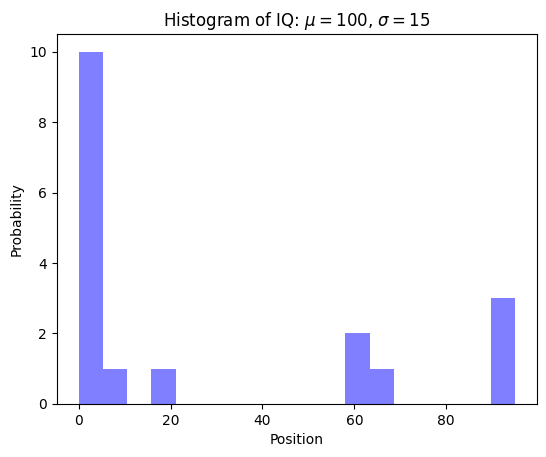

+----------+-------+-----------------------------------------------+------------------------------+
| Position | Fails |                % Fails by Case                |     # Fails by Patterns      |
+----------+-------+-----------------------------------------------+------------------------------+
|    0     |   0%  |                                               |                              |
|    1     |   0%  |                                               |                              |
|    2     |   0%  |                                               |                              |
|    3     |   0%  |                                               |                              |
|    4     |   0%  |                                               |                              |
|    5     |   0%  |                                               |                              |
|    6     |   0%  |                                               |                              |


In [ ]:
print_config()
print("num_questions=", num_questions, "min_useful_position=", ccfg.min_useful_position, "max_useful_position=", ccfg.max_useful_position )
print()

plt.hist(ccfg.perc_list, cfg.n_ctx, facecolor='blue', alpha=0.5)
plt.xlabel('Position')
plt.ylabel('Probability')
plt.title(r'Histogram of IQ: $\mu=100$, $\sigma=15$')
# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()

print(ccfg.output.get_formatted_string(out_format=cfg.table_out_format))

# Part 13: Setup: Cell matrix

Uses "u_" prefix.

In [ ]:
class UsefulCell():
  # Is this cell an attention head? If not, it must be an MLP layer
  is_head: bool = True

  position: int = 0  # token-position
  layer: int = 0
  head: int = 0


# We (once) calculate the list of cells (attention head and MLP layers per position) that are useful to the model.
calc_useful_cells = True
# Once this list of useful cells is calculated (available) it is used to speed up functions.
useful_cells = []


def add_useful_cell(the_is_head, the_position, the_layer, the_head):
  global calc_useful_cells
  global useful_cells

  if calc_useful_cells:
    useful_cell = UsefulCell()
    useful_cell.is_head = the_is_head
    useful_cell.position = the_position
    useful_cell.layer = the_layer
    useful_cell.head = the_head

    useful_cells = useful_cells + [useful_cell]

In [ ]:
class U_Config():
  # This is a head+MLP (row) by token (column) matrix of percent of failure percentages with associated notes
  fail_percs = [[]]
  fail_notes = [[]]
  num_heads = 0
  num_mlps = 0


ucfg = U_Config()

In [ ]:
def ucfg_reset():
  global ucfg

  ucfg.fail_percs = [[0 for _ in range(cfg.n_ctx)] for _ in range((cfg.n_heads + 1) * cfg.n_layers)]
  ucfg.fail_notes = [["" for _ in range(cfg.n_ctx)] for _ in range((cfg.n_heads + 1) * cfg.n_layers)]
  ucfg.num_heads = 0
  ucfg.num_mlps = 0


ucfg_reset()

In [ ]:
def add_u_fail_perc( the_position, the_layer, the_head, perc_fails, notes ):
  global ucfg

  the_row = the_layer * (cfg.n_heads+1) + the_head

  if ucfg.fail_percs[the_row][the_position] == 0 :
    ucfg.fail_percs[the_row][the_position] = perc_fails

    add_useful_cell(the_head != cfg.n_heads, the_position, the_layer, the_head)

  else:
    print( "add_u_fail_perc: Bad index", the_row, the_position)

  ucfg.fail_percs[the_row][the_position] = perc_fails
  ucfg.fail_notes[the_row][the_position] = notes


def add_head_fail_perc( the_position, the_layer, the_head, perc_fails, notes ):
  global ucfg

  add_u_fail_perc( the_position, the_layer, the_head, perc_fails, notes )
  ucfg.num_heads += 1


def add_mlp_fail_perc( the_position, the_layer, perc_fails, notes ):
  global ucfg

  add_u_fail_perc( the_position, the_layer, cfg.n_heads, perc_fails, notes )
  ucfg.num_mlps += 1


def get_column_headings():
  datums = ["Position"]
  for i in range(ccfg.min_useful_position, ccfg.max_useful_position+1):
    datums = datums + ["P"+str(i)]
  return datums


def get_row_heading(i):
  head = i % (cfg.n_heads + 1)
  layer = i // (cfg.n_heads + 1)
  return ( "L" + str(layer) + "H" + str(head) ) if head < cfg.n_heads else "MLP "


# Print a 2 by 2 matrix of the percentage failures.
def print_u_fail_percs():
  global ucfg
  global mcfg

  print("The % failure rate when each head or MLP in each position is ablated, # failed heads =", ucfg.num_heads, ", # failed mlps =", ucfg.num_mlps )

  cell_output = PrettyTable()

  col_headings = get_column_headings()
  cell_output.field_names = col_headings

  num_rows = (cfg.n_heads + 1) * cfg.n_layers
  num_cols = ccfg.max_useful_position - ccfg.min_useful_position + 1
  percs_matrix = torch.zeros((num_rows, num_cols)).to(torch.int64)
  mask_matrix = torch.zeros((num_rows, num_cols)).to(torch.int64)
  row_headings = []

  for i in range(num_rows):
    row_heading = get_row_heading(i)
    row_headings = row_headings + [row_heading]

    datums = [row_heading]
    for j in range(num_cols):
      value = ucfg.fail_percs[i][ccfg.min_useful_position + j]
      datums = datums + ["" if value == 0 else str(value)+"%"]
      percs_matrix[i,j] = value
      mask_matrix[i,j] = ( value == 0 )

    cell_output.add_row(datums)

  # Display a 2D heat map of the percentages
  if use_sns == True:

    sns.set_theme(rc={"figure.dpi": 96}) # use higher resolution
    # %config InlineBackend.figure_format = "svg"
    sns.set(font_scale=0.8)
    sns.heatmap(utils.to_numpy(percs_matrix), annot=True, mask=utils.to_numpy(mask_matrix), cmap="YlGnBu", xticklabels=col_headings[1:], yticklabels=row_headings)
    plt.show()
  else:
    # Display a "pretty" table in html for use in blog
    print(cell_output.get_formatted_string(out_format=cfg.table_out_format))


# Print a 2 by 2 matrix of notes.
def print_u_fail_notes():
  global ucfg
  global mcfg

  print("The most common failure pattern (with associated failure #) when each head or MLP in each position is ablated")

  cell_output = PrettyTable()
  cell_output.field_names = get_column_headings()

  for i in range((cfg.n_heads + 1) * cfg.n_layers):
    datums = [get_row_heading(i)]
    for j in range(ccfg.min_useful_position, ccfg.max_useful_position+1):
      datums = datums + [ucfg.fail_notes[i][j]]
    cell_output.add_row(datums)

  print(cell_output.get_formatted_string(out_format=cfg.table_out_format))

# Part 14: Setup: Ablate each MLP in EACH position. Impact on Loss?
Ablating the MLP in each layer in each position and seeing if the loss increases shows which head+layer+MLP are used by the algorithm. Use "m_" prefix.

In [ ]:
class M_Config():
  position : int = 0  # zero-based token-position to ablate
  layer : int = 0 # zero-based layer to ablate. 0 to 1
  threshold : float = 0.12
  questions = varied_questions
  output = PrettyTable()
  hook_calls : int = 0


mcfg = M_Config()


def m_reset():
  global mcfg

  mcfg.output = PrettyTable()
  mcfg.output.field_names = ["Position", "MLP Layer", "% Fails", "% Fails by Case", "# Fails by Patterns"]
  mcfg.hook_calls = 0


def m_mlp_hook_post(value, hook):
  global mcfg

  mcfg.hook_calls += 1
  #print( "In m_mlp_hook_post", value.shape) # Get [1, 18, 2040] = ???, cfg.n_ctx, ???

  # Mean ablate. Copy the mean resid post values in position N to the MLP
  value[:,mcfg.position,:] =  mean_mlp_hook_post[:,mcfg.position,:].clone()


def m_perform_core(show_all = False):
  global mcfg

  the_hook = [(l_mlp_hook_post_name[mcfg.layer], m_mlp_hook_post)]
  loss_mean = predict_experiment_question(mcfg.questions, the_hook, mcfg.threshold)

  num_fails = total_case_fails()
  if show_all or (num_fails > 0):
    perc_fails = round(100 * num_fails / mcfg.questions.shape[0])
    (pattern_results, top_pattern) = get_pattern_fails()

    mcfg.output.add_row([str(mcfg.position), str(mcfg.layer), perc_fails, get_case_fails(), pattern_results])

    add_mlp_fail_perc( mcfg.position, mcfg.layer, perc_fails, top_pattern )


def m_perform(all_cells):
  global mcfg

  if cfg.n_digits >= 5 :
    ucfg_reset()
    m_reset()
    if all_cells:
      for mcfg.position in range(cfg.n_ctx):
        for mcfg.layer in range(cfg.n_layers):
          m_perform_core()
    else:
      for useful_cell in useful_cells:
        if not useful_cell.is_head:
          mcfg.position = useful_cell.position
          mcfg.layer = useful_cell.layer
          m_perform_core()


def m_print_results(title):
    global mcfg

    print_config()
    print()
    print(title, mcfg.questions.shape[0])
    print(mcfg.output.get_formatted_string(out_format=cfg.table_out_format))

# Part 15: Setup: Ablate EACH head in EACH position. Impact on Digit & Task Loss?
Ablating each head in each layer in each position and seeing if the loss increases shows which position+layer+head are used by the algorithm. Use "h_" prefix.

In [ ]:
class H_Config():
  position : int = 0 # zero-based token position to ablate. 0 to say 17
  layer : int = 0 # zero-based layer to ablate. 0 to 1
  head : int = 0 # zero-based head to ablate. 0 to 2
  threshold : float = 0.12
  questions = varied_questions
  output = PrettyTable()
  hook_calls: int = 0


hcfg = H_Config()


def h_reset():
  global hcfg

  hcfg.output = PrettyTable()
  hcfg.output.field_names = ["Position", "Layer", "Head", "% Fails", "% Fails by Case", "# Fails by Impact"]
  hcfg.hook_calls = 0


def h_set_attn_hook_z(value, hook):
  global hcfg

  hcfg.hook_calls += 1
  # print( "In h_set_attn_hook_z", value.shape) # Get [1, 18, 3, 170] = ???, cfg.n_ctx, cfg.n_heads, d_head

  # Mean ablate. Copy the mean resid post values in position N to all the batch questions
  value[:,hcfg.position,hcfg.head,:] = mean_attn_z[:,hcfg.position,hcfg.head,:].clone()


def h_perform_core(show_all = False):
  global hcfg

  the_hook = [(l_attn_hook_z_name[hcfg.layer], h_set_attn_hook_z)]
  loss_mean = predict_experiment_question(hcfg.questions, the_hook, hcfg.threshold)

  num_fails = total_case_fails()
  if show_all or (num_fails > 0):
    perc_fails = round(100 * num_fails / hcfg.questions.shape[0])
    (pattern_results, top_pattern) = get_pattern_fails()

    hcfg.output.add_row([str(hcfg.position), str(hcfg.layer), str(hcfg.head), perc_fails, get_case_fails(), pattern_results])

    add_head_fail_perc( hcfg.position, hcfg.layer, hcfg.head, perc_fails, top_pattern)

  return num_fails


def h_perform(all_cells):
  global hcfg

  if cfg.n_digits >= 5 :
    h_reset()
    if all_cells:
      for hcfg.position in range(ccfg.min_useful_position, ccfg.max_useful_position+1):
        for hcfg.layer in range(cfg.n_layers):
          for hcfg.head in range(cfg.n_heads):
            h_perform_core()
    else:
      for useful_cell in useful_cells:
        if useful_cell.is_head:
          hcfg.position = useful_cell.position
          hcfg.layer = useful_cell.layer
          hcfg.head = useful_cell.head
          h_perform_core()


def h_print_results(title, the_format=""):
  global hcfg

  print_config()
  print()
  print(title, hcfg.questions.shape[0], ", #hook_calls=", hcfg.hook_calls)

  if the_format == "":
    the_format = cfg.table_out_format
  print(hcfg.output.get_formatted_string(out_format=the_format))

# Part 16: Calculate show cell matrixes

Show the percentage failure rate (incorrect prediction) when individual Attention Heads and MLPs are ablated.

In [ ]:
def calc_cell_matrices(title, questions, all_cells):
  global mcfg
  global hcfg
  global verbose

  mcfg.questions = questions
  m_perform(all_cells)
  if verbose:
    m_print_results(title)

  hcfg.questions = questions
  h_perform(all_cells)
  if verbose:
    h_print_results(title)

In [ ]:
def print_cell_matrices():
  global verbose

  verbose = False

  print_config()
  print()
  print_u_fail_percs()
  print()
  print_u_fail_notes()

In [ ]:
def run_cell_matrices():
  global calc_useful_cells

  calc_useful_cells = True
  calc_cell_matrices("Varied questions", varied_questions, True)
  calc_useful_cells = False

  print_cell_matrices()


#PQ temp
#run_cell_matrices()

# Part 17 - Case Analysis
Just processing BA, MC, US9 questions

In [ ]:
calc_cell_matrices("BA questions", make_ba_questions(), False)

print_cell_matrices()

n_digits= 5 n_heads= 3 n_layers= 2 n_ctx= 18 seed= 129000 n_training_steps= 30000

The % failure rate when each head or MLP in each position is ablated, # failed heads = 0 , # failed mlps = 0
+----------+----+----+-----+-----+-----+-----+-----+-----+-----+
| Position | P8 | P9 | P10 | P11 | P12 | P13 | P14 | P15 | P16 |
+----------+----+----+-----+-----+-----+-----+-----+-----+-----+
|   L0H0   |    |    |     |     |     |     |     |     |     |
|   L0H1   |    |    |     |     |     |     |     |     |     |
|   L0H2   |    |    |     |     |     |     |     |     |     |
|   MLP    |    |    |     |     |     |     |     |     |     |
|   L1H0   |    |    |     |     |     |     |     |     |     |
|   L1H1   |    |    |     |     |     |     |     |     |     |
|   L1H2   |    |    |     |     |     |     |     |     |     |
|   MLP    |    |    |     |     |     |     |     |     |     |
+----------+----+----+-----+-----+-----+-----+-----+-----+-----+

The most common failure pat

In [ ]:
calc_cell_matrices("UC1 questions", make_uc1_questions(), False)

print_cell_matrices()

n_digits= 5 n_heads= 3 n_layers= 2 n_ctx= 18 seed= 129000 n_training_steps= 30000

The % failure rate when each head or MLP in each position is ablated, # failed heads = 0 , # failed mlps = 0
+----------+----+----+-----+-----+-----+-----+-----+-----+-----+
| Position | P8 | P9 | P10 | P11 | P12 | P13 | P14 | P15 | P16 |
+----------+----+----+-----+-----+-----+-----+-----+-----+-----+
|   L0H0   |    |    |     |     |     |     |     |     |     |
|   L0H1   |    |    |     |     |     |     |     |     |     |
|   L0H2   |    |    |     |     |     |     |     |     |     |
|   MLP    |    |    |     |     |     |     |     |     |     |
|   L1H0   |    |    |     |     |     |     |     |     |     |
|   L1H1   |    |    |     |     |     |     |     |     |     |
|   L1H2   |    |    |     |     |     |     |     |     |     |
|   MLP    |    |    |     |     |     |     |     |     |     |
+----------+----+----+-----+-----+-----+-----+-----+-----+-----+

The most common failure pat

In [ ]:
calc_cell_matrices("Simple US9 questions", make_simple_us9_questions(), False)

print_cell_matrices()

n_digits= 5 n_heads= 3 n_layers= 2 n_ctx= 18 seed= 129000 n_training_steps= 30000

The % failure rate when each head or MLP in each position is ablated, # failed heads = 0 , # failed mlps = 0
+----------+----+----+-----+-----+-----+-----+-----+-----+-----+
| Position | P8 | P9 | P10 | P11 | P12 | P13 | P14 | P15 | P16 |
+----------+----+----+-----+-----+-----+-----+-----+-----+-----+
|   L0H0   |    |    |     |     |     |     |     |     |     |
|   L0H1   |    |    |     |     |     |     |     |     |     |
|   L0H2   |    |    |     |     |     |     |     |     |     |
|   MLP    |    |    |     |     |     |     |     |     |     |
|   L1H0   |    |    |     |     |     |     |     |     |     |
|   L1H1   |    |    |     |     |     |     |     |     |     |
|   L1H2   |    |    |     |     |     |     |     |     |     |
|   MLP    |    |    |     |     |     |     |     |     |     |
+----------+----+----+-----+-----+-----+-----+-----+-----+-----+

The most common failure pat

In [ ]:
calc_cell_matrices("Cascade US9 questions", make_cascade_us9_questions(), False)

print_cell_matrices()

n_digits= 5 n_heads= 3 n_layers= 2 n_ctx= 18 seed= 129000 n_training_steps= 30000

The % failure rate when each head or MLP in each position is ablated, # failed heads = 0 , # failed mlps = 0
+----------+----+----+-----+-----+-----+-----+-----+-----+-----+
| Position | P8 | P9 | P10 | P11 | P12 | P13 | P14 | P15 | P16 |
+----------+----+----+-----+-----+-----+-----+-----+-----+-----+
|   L0H0   |    |    |     |     |     |     |     |     |     |
|   L0H1   |    |    |     |     |     |     |     |     |     |
|   L0H2   |    |    |     |     |     |     |     |     |     |
|   MLP    |    |    |     |     |     |     |     |     |     |
|   L1H0   |    |    |     |     |     |     |     |     |     |
|   L1H1   |    |    |     |     |     |     |     |     |     |
|   L1H2   |    |    |     |     |     |     |     |     |     |
|   MLP    |    |    |     |     |     |     |     |     |     |
+----------+----+----+-----+-----+-----+-----+-----+-----+-----+

The most common failure pat

#Part 18: SetUp: Calc and graph PCA decomposition

In [ ]:
tn_questions = 100

# These are n_digit addition questions where the first test_digits add up from 0 to 8
# Randomise the last test_digits-1 digits of both numbers
def make_t8_questions(test_digit):
    limit = 10 ** test_digit
    questions = []
    for i in range(tn_questions):
        x = random.randint(0, 8)
        y = random.randint(0, 8-x)
        x = x * limit + random.randint(0, limit-1)
        y = y * limit + random.randint(0, limit-1)
        questions.append([x, y])
    return make_questions(questions)


# These are n_digit addition questions where the first test_digits add up to 9
# Randomise the last test_digits-1 digits of both numbers
def make_t9_questions(test_digit):
    limit = 10 ** test_digit
    questions = []
    for i in range(tn_questions):
        x = random.randint(0, 9)
        y = 9 - x
        x = x * limit + random.randint(0, limit-1)
        y = y * limit + random.randint(0, limit-1)
        questions.append([x, y])
    return make_questions(questions)


# These are n_digit addition questions where the first test_digits add up to 10 to 18
# Randomise the last test_digits-1 digits of both numbers
def make_t10_questions(test_digit):
    limit = 10 ** test_digit
    questions = []
    for i in range(tn_questions):
        x = random.randint(1, 9)
        y = random.randint(10-x, 9)
        x = x * limit + random.randint(0, limit-1)
        y = y * limit + random.randint(0, limit-1)
        questions.append([x, y])
    return make_questions(questions)


def make_tricase_questions(test_digit):
  q1 = make_t8_questions(test_digit)
  q2 = make_t9_questions(test_digit)
  q3 = make_t10_questions(test_digit)

  questions = torch.vstack((q1, q2, q3))

  return questions

In [ ]:
# Do one Principal Component Analysis
def calc_tricase_pca(t_position, t_layer, t_head, t_digit):
  global tn_questions

  t_questions = make_tricase_questions(t_digit)
  #print('Sample t8 question:', t_questions[0].tolist())
  #print('Sample t9 question:', t_questions[tn_questions].tolist())
  #print('Sample t10 question:', t_questions[2*tn_questions].tolist())

  t_logits, t_cache = model.run_with_cache(t_questions)

  # Gather attention patterns for all the (randomly chosen) questions
  attention_outputs = []
  for i in range(len(t_questions)):

    # Output of individual heads, without final bias
    attention_cache=t_cache["result", t_layer, "attn"] # Output of individual heads, without final bias
    attention_output=attention_cache[i]  # Shape [n_ctx, n_head, d_model]
    attention_outputs.append(attention_output[t_position, t_head, :])

  attn_outputs = torch.stack(attention_outputs, dim=0).cpu()

  pca = PCA(n_components=6)
  pca.fit(attn_outputs)
  pca_attn_outputs = pca.transform(attn_outputs)

  title = 'P' + str(t_position) + '.L' + str(t_layer) + '.H'+str(t_head) + ', A'+str(t_digit)

  return (pca, pca_attn_outputs, title)


# Plot one PCA scatter graph
def graph_pca(pca, pca_attn_outputs, ax, title):
  global tn_questions

  ax.scatter(pca_attn_outputs[:tn_questions, 0], pca_attn_outputs[:tn_questions, 1], color='red', label='0-8') # t8 questions
  ax.scatter(pca_attn_outputs[tn_questions:2*tn_questions, 0], pca_attn_outputs[tn_questions:2*tn_questions, 1], color='green', label='9') # t9 questions
  ax.scatter(pca_attn_outputs[2*tn_questions:, 0], pca_attn_outputs[2*tn_questions:, 1], color='blue', label='10-18') # t10 questionsset

  if title != "" :
    ax.set_title(title)

In [ ]:
# Graph the PCA of Sn.Ln.Hn's attention pattern, using T8, T9, T10 questions that differ in the An digit
def add_one_pca_subplot(ax, t_position, t_layer, t_head, t_digit):
  pca, pca_attn_outputs, title = calc_tricase_pca(t_position, t_layer, t_head, t_digit)
  graph_pca( pca, pca_attn_outputs, ax, title)

In [ ]:
def save_plt_to_file( full_title ):
  if cfg.save_graph_to_file:
    filename = full_title.replace(" ", "_").replace(",", "").replace(":", "_")  + '.png'
    plt.savefig(filename)

#Part 19: PCA decomposition tri-state results

Plot attention heads in the positions 8 to 16 with a clear "tri-state" response to (exactly) one An.

In [ ]:
if cfg.n_digits == 5 and cfg.n_layers == 2 and use_pca :

  # graph all useful early cells
  fig, axs = plt.subplots(4, 2)
  fig.set_figheight(8)
  fig.set_figwidth(5)

  # Plot all useful attention heads in the positions 8 to 12 with the clearest An selected
  add_one_pca_subplot(axs[0, 0], 8, 0, 1, 2)    # S8.L0.H1 is clear only for A2
  add_one_pca_subplot(axs[0, 1], 9, 0, 1, 1)    # S9.L0.H1 is clear only for A1
  add_one_pca_subplot(axs[1, 0], 11, 0, 1, 3)   # S11.L0.H1 is clear only for A3
  add_one_pca_subplot(axs[1, 1], 11, 0, 2, 4)   # S11.L0.H2 is clear only for A4
  add_one_pca_subplot(axs[2, 0], 12, 0, 1, 3)   # S12.L0.H1 is clear only for A3
  add_one_pca_subplot(axs[2, 1], 13, 0, 1, 2)   # S13.L0.H1 is clear only for A2
  add_one_pca_subplot(axs[3, 0], 14, 0, 1, 1)   # S14.L0.H1 is clear only for A1

  lines_labels = [axs[0,0].get_legend_handles_labels()]
  lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
  fig.legend(lines, labels, loc='lower center', ncol=4)

  plt.tight_layout()
  save_plt_to_file('PCA_Trigrams')
  plt.show()

#Part 19B: PCA decomposition bi-state results

Plot attention heads in the positions 8 to 16 with a clear "bi-state" response to (exactly) one An.

In [ ]:
if cfg.n_digits == 5 and cfg.n_layers == 2 and use_pca :

  # graph all useful early cells
  fig, axs = plt.subplots(1, 2)
  fig.set_figheight(2)
  fig.set_figwidth(5)

  # Plot all useful attention heads in the positions 8 to 12 with the clearest An selected
  add_one_pca_subplot(axs[0], 10, 0, 1, 0)   # S10.L0.H1 is clear only for A0
  add_one_pca_subplot(axs[1], 15, 0, 1, 0)   # S15.L0.H1 is clear only for A0

  lines_labels = [axs[0].get_legend_handles_labels()]
  lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
  fig.legend(lines, labels, loc='lower center', ncol=4)

  plt.tight_layout()
  save_plt_to_file('PCA_Bigrams')
  plt.show()

In [ ]:
# Do one Principal Component Analysis and graph it
def run_one_tricase_pca(t_position, t_layer, t_head, t_digit):

  pca, pca_attn_outputs, title = calc_tricase_pca(t_position, t_layer, t_head, t_digit)

  # Plot the PCA results
  fig, ax = plt.subplots()
  graph_pca(pca, pca_attn_outputs, ax, "")

  full_title = 'PCA of attention: n_digits=' + str(cfg.n_digits) + ', ' + title
  plt.title(full_title + ', EVR[0]=' + str(round(pca.explained_variance_ratio_[0],3)) )

  plt.tight_layout()
  save_plt_to_file(full_title)
  plt.show()

  print( "First few principal components explain variance of:", pca.explained_variance_ratio_)

#Part 19C: PCA decomposition of useful cells with digits 0 to 4

Parts 19A and 19B are selective. This part is not. Use it to find (verify) the interesting parts.

In [ ]:
def graph_all_pca_results():

  for useful_cell in useful_cells:
      if useful_cell.is_head:
        position = useful_cell.position
        layer = useful_cell.layer
        head = useful_cell.head
        print( "PCA: position=", position, "layer=", layer, "head=", head)

        fig, axs = plt.subplots(3, 2)

        add_one_pca_subplot(axs[0, 0], position, layer, head, 0)
        add_one_pca_subplot(axs[0, 1], position, layer, head, 1)
        add_one_pca_subplot(axs[1, 0], position, layer, head, 2)
        add_one_pca_subplot(axs[1, 1], position, layer, head, 3)
        add_one_pca_subplot(axs[2, 0], position, layer, head, 4)

        plt.tight_layout()
        plt.show()


if use_pca :
  graph_all_pca_results()

# Part 20: Implement Mathematical framework

Demonstrates that the mathematical framework (not the model) can do 1,000,000 additions without error.

In [ ]:
def tri_case(dn,dnd):
  s = dn + dnd
  if s >= 10:
    return 10
  if s == 9:
    return 9
  return 8

def tri_add(dn_cx, dm_cy):
  if dn_cx == 10 or (dn_cx == 9 and dm_cy == 10):
    return 10
  if dn_cx == 8 and dm_cy == 10:
    return 9
  return 8

def addition_psuedo_code( d4, d3, d2, d1, d0, d4d, d3d, d2d, d1d, d0d ):
  # V2.C | TriCase(D2, D2’) | P8.L0.H1 and P8.L0.MLP
  v2_c = tri_case(d2, d2d)

  # V1.C | TriCase(D1, D1') | P9.L0.H1 and P9.L0.MLP
  v1_c = tri_case(d1, d1d)

  # V1.C2 | TriAdd(V1.C, TriCase(D0, D0’)) | P10.L0.H1 and P10.L0.MLP
  v1_c2 =  tri_add( v1_c, tri_case(d0, d0d) )

  # V3.C4 | TriAdd(TriCase(D3, D3’), TriAdd(V2.C,V1.C2)) | P11.L0.H1
  v3_c4 = tri_add( tri_case(d3, d3d), tri_add(v2_c,v1_c2) )

  # V4.C | TriCase(D4, D4’) | P11.L0.H2
  v4_c = tri_case(d4, d4d)

  # V4.C5 | TriAdd(V4.C, V3.C4) | P11.L0.MLP
  v4_c5 = tri_add(v4_c, v3_c4)

  # A5 | (V4.C5 == 10) | P11.L1.MLP
  a5 = 1 if v4_c5 == 10 else 0

  # V4.BA | (D4 + D4') % 10 | P12.L0.H0 + H2
  v4_ba = (d4 + d4d) % 10

  # V3.C4 | TriAdd(TriCase(D3, D3’), TriAdd(V2.C,V1.C2)) | P12.L0.H1
  v3_c4 = tri_add( tri_case(d3, d3d), tri_add(v2_c, v1_c2) )

  # A4 | (V4.BA + V3.C4 / 10) % 10 | P12.L0.MLP and P12.L1.MLP
  a4 = (v4_ba + (v3_c4 // 10)) % 10

  #V3.BA | (D3 + D3') % 10 | P13.L0.H0 + H2
  v3_ba = (d3 + d3d) % 10

  # V2.C3 | TriAdd(V2.C,V1.C2) | P13.L0.H1
  v2_c3 = tri_add(v2_c, v1_c2)

  # A3 | (V3.BA + V2.C3 / 10) % 10 | P13.L0.MLP and P13.L1.MLP
  a3 = (v3_ba + (v2_c3 // 10)) % 10

  # V2.BA | (D2 + D2') % 10 | P14.L0.H0 + H2
  v2_ba = (d2 + d2d) % 10

  # V1.C2 | Copy from P10 | P14.L0.H1
  # skip

  # A2 | (V2.BA + V1.C2 / 10) % 10 | P14.L0.MLP and P14.L1.MLP
  a2 = (v2_ba + (v1_c2 // 10)) % 10

  # V1.BA | (D1 + D1') % 10 | P15.L0.H0 + H2
  v1_ba = (d1 + d1d) % 10

  # D0.MC | (D0 + D0') // 10 | P15.L0.H1
  v0_mc = (d0 + d0d) // 10

  # A1 | (V1.BA + D0.MC) % 10 | P15.L0.MLP and P15.L1.MLP
  a1 = (v1_ba + v0_mc) % 10

  # A0 | (D0 + D0') % 10 | P16.L0.H0 + H2 P16.L0.MLP and P16.L1.MLP
  a0 = (d0 + d0d) % 10

  return a5, a4, a3, a2, a1, a0


def do_addition_question(question):
  if cfg.n_digits == 5:
    d4 = int(question[0])
    d3 = int(question[1])
    d2 = int(question[2])
    d1 = int(question[3])
    d0 = int(question[4])
    d4d = int(question[6])
    d3d = int(question[7])
    d2d = int(question[8])
    d1d = int(question[9])
    d0d = int(question[10])

    a5, a4, a3, a2, a1, a0 = addition_psuedo_code( d4, d3, d2, d1, d0, d4d, d3d, d2d, d1d, d0d)

    d = d4 * 10000 + d3 * 1000 + d2 * 100 + d1 * 10 + d0
    dd = d4d * 10000 + d3d * 1000 + d2d * 100 + d1d * 10 + d0d
    a = a5 * 100000 + a4 * 10000 + a3 * 1000 + a2 * 100 + a1 * 10 + a0

    if d + dd != a :
      print(d4, d3, d2, d1, d0, "+" ,d4d, d3d, d2d, d1d, d0d, "=", a5, a4, a3, a2, a1, a0 )
      print("Bad addition:", d, "+", dd, "=", a, "Should be", d+dd, "Delta", d+dd-a)
      return False

    return True

In [ ]:
def verify_mathematical_framework():
  if cfg.n_digits == 5:
    num_successes = 0;
    num_fails = 0

    num_batches = 1000000//cfg.batch_size
    for epoch in range(num_batches):
      tokens, _, _, _, _, _ = next(ds)

      for i in range(cfg.batch_size):
        if not do_addition_question(tokens[i]):
          num_fails += 1

      if num_fails > 0:
        break

      num_successes += cfg.batch_size
      if epoch % 250 == 0:
          print("Batch", epoch, "of", num_batches, "#Successes=", num_successes)

    print("successes", num_successes, "num_fails", num_fails)


#verify_mathematical_framework()

# Part 21A : Set Up Interchange Interventions

Here we test our mapping of our mathematical framework (causual abstraction) to the model attention heads.







In [ ]:
class A_Config():
  token_position : int = 15 # The token position we want to get/set. P8 to P11 contribute to A5 calculations
  layer : int = 0 # The layer we want to get/set
  heads = [] # The heads we want to get/set
  threshold : int = 0.00001

  hook_calls: int = 0
  answer_failures : int = 0    # Failures of any digit

  questions = []
  store = []

  null_hooks = []
  get_hooks = []
  put_hooks = []


acfg = A_Config()

In [ ]:
# Get and put attention head value hooks

def a_null_attn_z_hook(value, hook):
  global acfg

  acfg.hook_calls += 1
  #print("In a_null_attn_z_hook", value.shape)  # Get [1, 18, 3, 170] = ???, cfg.n_ctx, cfg.n_heads, cfg.d_head


def a_get_l0_attn_z_hook(value, hook):
  global acfg

  if acfg.layer == 0:
    acfg.hook_calls += 1
    # print( "In a_get_l0_attn_z_hook", value.shape) # Get [1, 18, 3, 170] = ???, cfg.n_ctx, cfg.n_heads, cfg.d_head
    acfg.store = value.clone()


def a_get_l1_attn_z_hook(value, hook):
  global acfg

  if acfg.layer == 1:
    acfg.hook_calls += 1
    # print( "In acfg.get_l1_attn_z_hook", value.shape) # Get [1, 18, 3, 170] = ???, cfg.n_ctx, cfg.n_heads, cfg.d_head
    acfg.store = value.clone()


def a_put_l0_attn_z_hook(value, hook):
  global acfg

  if acfg.layer == 0:
    acfg.hook_calls += 1
    # print( "In a_l0_attn_z_hook", value.shape) # Get [1, 18, 3, 170] = ???, cfg.n_ctx, cfg.n_heads, d_head
    for head_index in acfg.heads:
      value[:,acfg.token_position,head_index,:] = acfg.store[:,acfg.token_position,head_index,:].clone()


def a_put_l1_attn_z_hook(value, hook):
  global acfg

  if acfg.layer == 1:
    acfg.hook_calls += 1
    # print( "In a_put_l1_attn_z_hook", value.shape) # Get [1, 18, 3, 170] = ???, cfg.n_ctx, cfg.n_heads, d_head
    for head_index in acfg.heads:
      value[:,acfg.token_position,head_index,:] = acfg.store[:,acfg.token_position,head_index,:].clone()


def a_reset(token_position, layer, heads):
  global acfg

  acfg.token_position = token_position
  acfg.layer = layer
  acfg.heads = heads

  acfg.hook_calls = 0
  acfg.answer_failures = 0

  acfg.null_hooks = [(l_attn_hook_z_name[0], a_null_attn_z_hook)]
  acfg.get_hooks = [(l_attn_hook_z_name[0], a_get_l0_attn_z_hook),(l_attn_hook_z_name[1], a_get_l1_attn_z_hook)]
  acfg.put_hooks = [(l_attn_hook_z_name[0], a_put_l0_attn_z_hook),(l_attn_hook_z_name[1], a_put_l1_attn_z_hook)]

In [ ]:
def a_predict_question(description, the_hooks, always):
  global acfg
  global model

  acfg.hook_calls = 0
  acfg.answer_failures = 0

  for question_num in range(acfg.questions.shape[0]):
    q = acfg.questions[question_num]

    i = 12
    a = q[i+0] * 100000 + q[i+1] * 10000 + q[i+2] * 1000 + q[i+3] * 100 + q[i+4] * 10 + q[i+5]

    model.reset_hooks()
    model.set_use_attn_result(True)
    exp_logits = model.run_with_hooks(q.cuda(), return_type="logits", fwd_hooks=the_hooks)

    q_2d = q.unsqueeze(0)
    exp_losses_raw, exp_max_indices = logits_to_tokens_loss(exp_logits, q_2d.cuda())
    loss_mean = utils.to_numpy(loss_fn(exp_losses_raw).mean())

    answer_str = prediction_to_string(exp_max_indices)

    match_str = ""
    if loss_mean > acfg.threshold:
      acfg.answer_failures += 1
      match_str = get_digit_accuracy_impact( a, answer_str )
    if match_str == "":
      match_str = "(none)"

    if always or (loss_mean > acfg.threshold):
      loss_str = "(none)" if loss_mean < 1e-7 else str(loss_mean)

      print(description, "  ModelPredicts:", answer_str, "  DigitsImpacted:", match_str, "  Loss:", loss_str)


In [ ]:
def a_run_intervention_core(token_position, layer, heads, store_question, alter_question):
  a_reset(token_position, layer, heads)

  # Predict first question and store activation values (including the Vn.BA)
  acfg.questions = make_questions([store_question])
  a_predict_question("Unit test (null hook)", acfg.null_hooks, False)
  a_predict_question("Store activation", acfg.get_hooks, False)

  # Predict second question. Then rerun overriding Pn_Lm_Hp to give bad answer
  acfg.questions = make_questions([alter_question])
  a_predict_question("Unit test (null hook)", acfg.null_hooks, False)
  prompt = "Intervening on P" + str(token_position) + ".L" + str(layer) + ".H"
  for head_index in acfg.heads:
    prompt += str(head_index) + ","
  a_predict_question(prompt, acfg.put_hooks, True)


def a_run_intervention(description, token_position, layer, heads, store_question, alter_question):
  if cfg.n_digits == 5 and cfg.n_layers == 2:
    print(description)
    a_run_intervention_core(token_position, layer, heads, store_question, alter_question)
    print()

# Part 21B : Run Interchange Interventions

Here we test our mapping of our mathematical framework (casual abstraction) to the model attention heads.


In [ ]:
print( "Test claim that P8.L0.H1 performs V2.C = TriCase(D2, D2’) impacting A4 and A5 accuracy")
print()

store_question = [44444, 55555] # Sum is 099999. V2 has no MC.
alter_question = [11111, 11111] # Sum is 022222. V2 has no MC.
a_run_intervention("No V2.MC: No impact expected", 8, 0, [1], store_question, alter_question)

store_question = [77711, 22711] # Sum is 100422. V2 has MC
alter_question = [44444, 55555] # Sum is 099999. V2 has no MC
a_run_intervention("Insert V2.MC: Expect A54 digit impacts. Expect 109999.", 8, 0, [1], store_question, alter_question)

store_question = [17711, 22711] # Sum is 035422. V2 has MC
alter_question = [ 4444,  5555] # Sum is 009999. V2 has no MC
a_run_intervention("Insert V2.MC: Expect A4 digit impact. Expect 019999.", 8, 0, [1], store_question, alter_question)

# Confirmed that P8.L0.H1 is: Based on D2 and D2'. Triggers on a V2 carry value. Provides "carry 1" used in A5 and A4 calculation.

Test claim that P8.L0.H1 performs V2.C = TriCase(D2, D2’) impacting A4 and A5 accuracy

No V2.MC: No impact expected
Intervening on P8.L0.H1,   ModelPredicts: 022222   DigitsImpacted: (none)   Loss: (none)

Insert V2.MC: Expect A54 digit impacts. Expect 109999.
Intervening on P8.L0.H1,   ModelPredicts: 109999   DigitsImpacted: A54   Loss: 5.299321775692151

Insert V2.MC: Expect A4 digit impact. Expect 019999.
Intervening on P8.L0.H1,   ModelPredicts: 019999   DigitsImpacted: A4   Loss: 3.2266855051444985



In [ ]:
print( "Test claim that P9.L0.H1 performs V1.C = TriCase(D1, D1’) impacting A5, A4 & A3 accuracy")
print()

store_question = [ 44444, 55555] # Sum is 099999. V1 has no MC.
alter_question = [ 11111, 11111] # Sum is 022222. V1 has no MC
a_run_intervention("No V1.MC: No impact expected", 9, 0, [1], store_question, alter_question)

store_question = [ 11171, 11171] # Sum is 022342. V1 has MC
alter_question = [ 44444, 55555] # Sum is 099999. V1 has no MC.
a_run_intervention("Insert V1.MC: Expect A543 digit impacts. Expect 100999.", 9, 0, [1], store_question, alter_question)

store_question = [ 11171, 11171] # Sum is 022342. V1 has MC
alter_question = [  4444,  5555] # Sum is 009999. V1 has no MC
a_run_intervention("Insert V1.MC: Expect A43 digit impacts. Expect 010999.", 9, 0, [1], store_question, alter_question)

store_question = [ 11171, 11171] # Sum is 022342. V1 has MC
alter_question = [   444,   555] # Sum is 000999. V1 has no MC
a_run_intervention("Insert V1.MC: Expect A3 digit impact. Expect 001999.", 9, 0, [1], store_question, alter_question)

# Confirmed that P9.L0.H1 is: Based on D1 and D1'. Triggers on a V1 carry value. Provides "carry 1" used in A5, A4 & A3 calculation.

Test claim that P9.L0.H1 performs V1.C = TriCase(D1, D1’) impacting A5, A4 & A3 accuracy

No V1.MC: No impact expected
Intervening on P9.L0.H1,   ModelPredicts: 022222   DigitsImpacted: (none)   Loss: (none)

Insert V1.MC: Expect A543 digit impacts. Expect 100999.
Intervening on P9.L0.H1,   ModelPredicts: 100999   DigitsImpacted: A543   Loss: 5.7620570817856755

Insert V1.MC: Expect A43 digit impacts. Expect 010999.
Intervening on P9.L0.H1,   ModelPredicts: 010999   DigitsImpacted: A43   Loss: 4.482176019303971

Insert V1.MC: Expect A3 digit impact. Expect 001999.
Intervening on P9.L0.H1,   ModelPredicts: 001999   DigitsImpacted: A3   Loss: 3.2911737233840377



In [ ]:
print( "Test claim that P10.L0.H1 performs V1.C2 = TriAdd(V1.C, TriCase(D0, D0’)) impacting A5, A4, A3 & A2 accuracy")
print()

store_question = [ 11111, 33333] # Sum is 044444. V0 has no MC.
alter_question = [ 44444, 55555] # Sum is 099999. V0 has no MC
a_run_intervention("No impact expected", 10, 0, [1], store_question, alter_question)
# Results: No impact as expected

store_question = [ 11117, 11117] # Sum is 022234. V0 has MC
alter_question = [ 44444, 55555] # Sum is 099999. V0 has no MC
a_run_intervention("Insert D0.MC: Expect A5432 digit impacts. Expect 100099.", 10, 0, [1], store_question, alter_question)
# Results: Impact on A5432 as expected. Got expected value 100099

store_question = [ 11117, 11117] # Sum is 022234. V0 has MC
alter_question = [  4444,  5555] # Sum is 009999. V0 has no MC
a_run_intervention("Insert D0.MC: Expect A432 digit impacts. Expect 010099.", 10, 0, [1], store_question, alter_question)

store_question = [ 11117, 11117] # Sum is 022234. V0 has MC
alter_question = [   444,   555] # Sum is 000999. V0 has no MC
a_run_intervention("Insert D0.MC: Expect A32 digit impacts. Expect 001099", 10, 0, [1], store_question, alter_question)

store_question = [ 11117, 11117] # Sum is 022234. V0 has MC
alter_question = [    44,    55] # Sum is 000099. V0 has no MC
a_run_intervention("Insert D0.MC Expect A2 digit impacts. Expect 000199", 10, 0, [1], store_question, alter_question)

# Confirmed that P10.L0.H1 is: Based on D0 and D0'. Triggers on a V0 carry value. Provides "carry 1" used in A5, A4, A3 & A2 calculation.

Test claim that P10.L0.H1 performs V1.C2 = TriAdd(V1.C, TriCase(D0, D0’)) impacting A5, A4, A3 & A2 accuracy

No impact expected
Intervening on P10.L0.H1,   ModelPredicts: 099999   DigitsImpacted: (none)   Loss: (none)

Insert D0.MC: Expect A5432 digit impacts. Expect 100099.
Intervening on P10.L0.H1,   ModelPredicts: 100099   DigitsImpacted: A5432   Loss: 10.939795728734431

Insert D0.MC: Expect A432 digit impacts. Expect 010099.
Intervening on P10.L0.H1,   ModelPredicts: 010099   DigitsImpacted: A432   Loss: 9.112591770139232

Insert D0.MC: Expect A32 digit impacts. Expect 001099
Intervening on P10.L0.H1,   ModelPredicts: 001099   DigitsImpacted: A32   Loss: 6.3806896571810405

Insert D0.MC Expect A2 digit impacts. Expect 000199
Intervening on P10.L0.H1,   ModelPredicts: 000199   DigitsImpacted: A2   Loss: 3.3800129445057565



In [ ]:
print( "Test claim that P11.L0.H1 performs V3.C4 = TriAdd(TriCase(D3, D3’),TriAdd(V2.C,V1.C2)) impacting A5 accuracy")
print()

store_question = [44444, 44444] # Sum is 088888. V3 sums to 8 (has no MC).
alter_question = [11111, 11111] # Sum is 022222. V3 has no MC.
a_run_intervention("No V3.MC: No impact expected", 11, 0, [1], store_question, alter_question)

store_question = [16111, 13111] # Sum is 032111. V3 sums to 9 (has no MC).
alter_question = [44444, 55555] # Sum is 099999. V3 has no MC
a_run_intervention("No V3.MC: No impact expected", 11, 0, [1], store_question, alter_question)

store_question = [16111, 16111] # Sum is 032111. V3 has MC
alter_question = [44444, 55555] # Sum is 099999. V3 has no MC
a_run_intervention("Insert V3.MC: Expect A5 digit impact. Expect 199999.", 11, 0, [1], store_question, alter_question)

# Confirmed that P11.L0.H1 is: Based on D3 and D3'. Triggers on a V3 carry value. Provides "carry 1" used in A5 calculations.

Test claim that P11.L0.H1 performs V3.C4 = TriAdd(TriCase(D3, D3’),TriAdd(V2.C,V1.C2)) impacting A5 accuracy

No V3.MC: No impact expected
Intervening on P11.L0.H1,   ModelPredicts: 022222   DigitsImpacted: (none)   Loss: (none)

No V3.MC: No impact expected
Intervening on P11.L0.H1,   ModelPredicts: 099999   DigitsImpacted: (none)   Loss: (none)

Insert V3.MC: Expect A5 digit impact. Expect 199999.
Intervening on P11.L0.H1,   ModelPredicts: 199999   DigitsImpacted: A5   Loss: 3.042900461498787



In [ ]:
print( "Test claim that P11.L0.H2 performs V4.C = TriCase(D4, D4’) impacting A5 accuracy")
print()

store_question = [44444, 55555] # Sum is 099999. V4 has no MC.
alter_question = [11111, 11111] # Sum is 022222. V4 has no MC.
a_run_intervention("No V4.MC: No impact expected", 11, 0, [2], store_question, alter_question)

store_question = [71111, 71111] # Sum is 100422. V4 has MC
alter_question = [44444, 55555] # Sum is 099999. V4 has no MC
a_run_intervention("Insert V4.MC: Expect A5 digit impact. Expect 199999.", 11, 0, [2], store_question, alter_question)

# Confirmed that P9.L0.H2 is: Based on D4 and D4'. Triggers on a V4 carry value. Provides "carry 1" used in A5 calculation.

Test claim that P11.L0.H2 performs V4.C = TriCase(D4, D4’) impacting A5 accuracy

No V4.MC: No impact expected
Intervening on P11.L0.H2,   ModelPredicts: 022222   DigitsImpacted: (none)   Loss: (none)

Insert V4.MC: Expect A5 digit impact. Expect 199999.
Intervening on P11.L0.H2,   ModelPredicts: 199999   DigitsImpacted: A5   Loss: 4.241032295606187



In [ ]:
print( "Test claim that P12.L0.H0 and H2 performs V4.BA = (D4 + D4’) % 10 impacting A4 accuracy")
print()

store_question = [72222, 71111] # Sum is 143333
alter_question = [12342, 56573] # Sum is 068915
a_run_intervention("Override D4/D4'. Expect A4 digit impact. Expect 048915", 12, 0, [0,2], store_question, alter_question)

# Confirmed that P12.L0.H0+H2 is: Adds D4 and D4'. Impacts A4

Test claim that P12.L0.H0 and H2 performs V4.BA = (D4 + D4’) % 10 impacting A4 accuracy

Override D4/D4'. Expect A4 digit impact. Expect 048915
Intervening on P12.L0.H0,2,   ModelPredicts: 048915   DigitsImpacted: A4   Loss: 5.231093744310888



In [ ]:
print( "Test claim that P13.L0.H0 and H2 performs V3.BA = (D3 + D3’) % 10 impacting A3 accuracy")
print()

store_question = [23222, 13111] # Sum is 36333
alter_question = [12342, 56573] # Sum is 68915
a_run_intervention("Override D3/D3'. Expect A3 digit impact. Expect 66915", 13, 0, [0,2], store_question, alter_question)

# Confirmed that P13.L0.H0+H2 is: Adds D3 and D3'. Impacts A3

Test claim that P13.L0.H0 and H2 performs V3.BA = (D3 + D3’) % 10 impacting A3 accuracy

Override D3/D3'. Expect A3 digit impact. Expect 66915
Intervening on P13.L0.H0,2,   ModelPredicts: 066915   DigitsImpacted: A3   Loss: 5.7013734450862685



In [ ]:
print( "Test claim that P14.L0.H0 and H2 performs V2.BA = (D2 + D2’) % 10 impacting A2 accuracy")
print()

store_question = [22322, 11311] # Sum is 33633. No V1.MC
alter_question = [12342, 56573] # Sum is 68915. Has V1.MC
a_run_intervention("Override D2/D2'. Expect A2 digit impact. Expect 68715", 14, 0, [0,2], store_question, alter_question)

store_question = [22322, 11311] # Sum is 33633. No V1.MC
alter_question = [12133, 56133] # Sum is 68266. No V1.MC
a_run_intervention("Override D2/D2'. Expect A2 digit impact. Expect 68666", 14, 0, [0,2], store_question, alter_question)

# Confirmed that P12.L0.H0 and H2 both impact A2, and together sum D2 and D2'

Test claim that P14.L0.H0 and H2 performs V2.BA = (D2 + D2’) % 10 impacting A2 accuracy

Override D2/D2'. Expect A2 digit impact. Expect 68715
Intervening on P14.L0.H0,2,   ModelPredicts: 068715   DigitsImpacted: A2   Loss: 4.770342229769021

Override D2/D2'. Expect A2 digit impact. Expect 68666
Intervening on P14.L0.H0,2,   ModelPredicts: 068666   DigitsImpacted: A2   Loss: 3.592845763765798



In [ ]:
print( "Test claim that P14.L0.H1 calculates V1.C1 but also relies on P10.V1.C2, impacting A2 accuracy")
print()


store_question = [55555, 44454] # Sum is 100009. Has V1.MC
alter_question = [22222, 33333] # Sum is 055555. No V1.MC
a_run_intervention("Override V1.MC impacting V1.C1. Expect A2 digit impact. Expect 055655", 14, 0, [1], store_question, alter_question) # Get 055655. Correct
a_run_intervention("Override V1.MC impacting V1.C1. Expect A2 digit impact. Expect 055655", 10, 0, [1], store_question, alter_question) # Get 055555. No impact.

store_question = [55590, 44490] # Sum is 100080. Has V1.MC
alter_question = [12345, 54321] # Sum is 066666. No V1.MC
a_run_intervention("Override V1.MC impacting V1.C1. Expect A2 digit impact. Expect 066766", 14, 0, [1], store_question, alter_question) # Get 066766. Correct
a_run_intervention("Override V1.MC impacting V1.C1. Expect A2 digit impact. Expect 066766", 10, 0, [1], store_question, alter_question) # Get 066666. No impact.

store_question = [12345, 54321] # Sum is 066666. No V1.MC
alter_question = [55590, 44490] # Sum is 100080. Has V1.MC
a_run_intervention("Override V1.MC impacting V1.C1. Expect A2 digit impact. Expect 100980", 14, 0, [1], store_question, alter_question) # Get 100980. Correct
a_run_intervention("Override V1.MC impacting V1.C1. Expect A2 digit impact. Expect 100980", 10, 0, [1], store_question, alter_question) # Get 100080. No impact.

# Above shows:
# - P14.L0.H1 behaviour is different from P10.L0.H1 behaviour
# - P14.L0.H1 does not simply copy P10.L0.H1 (although this would be a valid way to get perfect accuracy in A2)
print()

store_question = [12345, 54321] # Sum is 066666. No V1.MC
alter_question = [55555, 44445] # Sum is 100000. Has V0.MC, V1.MC, V1.C2
a_run_intervention("Override V1.MC impacting V1.C2. Expect A2 digit impact. Expect 100900", 14, 0, [1], store_question, alter_question) # Get 100900. Correct
a_run_intervention("Override V1.MC impacting V1.C1. Expect A2 digit impact. Expect 099900", 10, 0, [1], store_question, alter_question) # Get 099900. Correct

store_question = [22222, 33333] # Sum is 055555. No V1.MC
alter_question = [66663, 33337] # Sum is 100000. Has V0.MC, V1.MC, V1.C2
a_run_intervention("Override V1.MC impacting V1.C2. Expect A2 digit impact. Expect 100900", 14, 0, [1], store_question, alter_question) # Get 100900. Correct
a_run_intervention("Override V1.MC impacting V1.C1. Expect A2 digit impact. Expect 099900", 10, 0, [1], store_question, alter_question) # Get 099900. Correct

# Above shows:
# - P14.L0.H1 does rely on P10.L0.H1 for V1.C2 information when V1.C != V1.C2
# - P14.L0.H1 calculates V1.C information itself from D1+D1'.

# Overall confirmed: P14.L0.H1 calculates V1.C1 but also relies on P10.V1.C2 when V1.C != V1.C2. Impacts A2

Test claim that P14.L0.H1 calculates V1.C1 but relies on P10.L0.H1 when V1.C != V1.C2, impacting A2 accuracy

Override V1.MC impacting V1.C1. Expect A2 digit impact. Expect 055655
Intervening on P14.L0.H1,   ModelPredicts: 055655   DigitsImpacted: A2   Loss: 2.929285317710518

Override V1.MC impacting V1.C1. Expect A2 digit impact. Expect 055655
Intervening on P10.L0.H1,   ModelPredicts: 055555   DigitsImpacted: (none)   Loss: (none)

Override V1.MC impacting V1.C1. Expect A2 digit impact. Expect 066766
Intervening on P14.L0.H1,   ModelPredicts: 066766   DigitsImpacted: A2   Loss: 3.0677803987390844

Override V1.MC impacting V1.C1. Expect A2 digit impact. Expect 066766
Intervening on P10.L0.H1,   ModelPredicts: 066666   DigitsImpacted: (none)   Loss: (none)

Override V1.MC impacting V1.C1. Expect A2 digit impact. Expect 100980
Intervening on P14.L0.H1,   ModelPredicts: 100980   DigitsImpacted: A2   Loss: 3.2824652714725233

Override V1.MC impacting V1.C1. Expect A2 digit impact. Expect

In [ ]:
print( "Test claim that P15.L0.H0 and H2 performs V1.BA = (D1 + D1’) % 10 impacting A1 accuracy")
print()

store_question = [22242, 11141] # Sum is 33383. No V0.MC
alter_question = [12322, 56523] # Sum is 68845. No V0.MC
a_run_intervention("Override D1/D1'. Expect A1 digit impact. Expect 68885", 15, 0, [0,2], store_question, alter_question)

# Confirmed that P15.L0.H0 and H2 both impact A1, and together sum D1 and D1'

Test claim that P15.L0.H0 and H2 performs V1.BA = (D1 + D1’) % 10 impacting A1 accuracy

Override D1/D1'. Expect A1 digit impact. Expect 68885
Intervening on P15.L0.H0,2,   ModelPredicts: 068885   DigitsImpacted: A1   Loss: 3.1104054715185985



In [ ]:
print( "Test claim that P15.L0.H1 performs V0.MC = (D0 + D0’) / 10 impacting A1 (A one) accuracy")
print()

store_question = [22244, 11149] # Sum is 33393. Has V0.MC
alter_question = [12342, 56513] # Sum is 68855. No V0.MC
a_run_intervention("Override D0.MC. Expect A1 digit impact. Expect 68865", 15, 0, [1], store_question, alter_question)

# Now test counter-claim that an intervention where both questions do NOT generate a D0.MC has NO impact on A1
store_question = [22242, 11141] # Sum is 33383. No V0.MC
alter_question = [12342, 56523] # Sum is 68865. No V0.MC
a_run_intervention("No impact expected", 15, 0, [1], store_question, alter_question)

# Confirmed that P15.L0.H1: Triggers when D0 + D0' > 10. Impacts A1 digit by 1

Test claim that P15.L0.H1 performs V0.MC = (D0 + D0’) / 10 impacting A1 (A one) accuracy

Override D0.MC. Expect A1 digit impact. Expect 68865
Intervening on P15.L0.H1,   ModelPredicts: 068865   DigitsImpacted: A1   Loss: 3.142588321866339

No impact expected
Intervening on P15.L0.H1,   ModelPredicts: 068865   DigitsImpacted: (none)   Loss: (none)



In [ ]:
print( "Test claim that P16.L0.H0 and H2 performs D0.BA = (D0 + D0’) % 10 impacting A0 accuracy")
print()

store_question = [22225, 11114] # Sum is 33339
alter_question = [12342, 56563] # Sum is 68905
a_run_intervention("Override D0/D0'. Expect A0 digit impact. Expect 68909", 16, 0, [0,2], store_question, alter_question)

store_question = [22228, 11119] # Sum is 33347
alter_question = [12342, 56563] # Sum is 68905
a_run_intervention("Override D0/D0'. Expect A0 digit impact. Expect 68907", 16, 0, [0,2], store_question, alter_question)

# Confirmed that P16.L0.H0 and H2 both impact A0, and together sum D0 and D0'

Test claim that P16.L0.H0 and H2 performs D0.BA = (D0 + D0’) % 10 impacting A0 accuracy

Override D0/D0'. Expect A0 digit impact. Expect 68909
Intervening on P16.L0.H0,2,   ModelPredicts: 068909   DigitsImpacted: A0   Loss: 3.4497020070222266

Override D0/D0'. Expect A0 digit impact. Expect 68907
Intervening on P16.L0.H0,2,   ModelPredicts: 068907   DigitsImpacted: A0   Loss: 5.963881366152209



#Part 22: MLP Visualisation (incomplete, on-hold)

interactive(children=(IntText(value=0, description='Index:'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_mlp_neuron_activation(pos: int)>

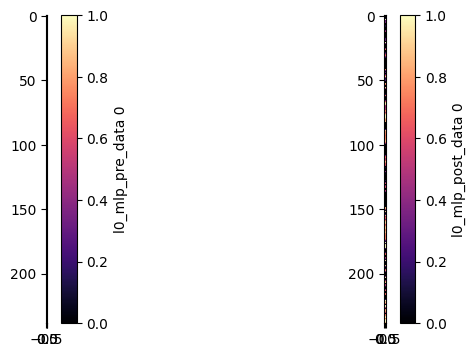

In [ ]:
import einops
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output


# number of questions in batch that generated sample_cache
num_questions = 239


def get_mlp_data(data_set_name):

  data_set = sample_cache[data_set_name]
  # print( data_set_name + " shape", data_set.shape) # 239, 18, 2040 = num_questions, n_ctx, d_mlp

  raw_data = data_set[:,-3]
  # print( "raw_data shape", raw_data.shape) # 239, 2040 = num_questions, d_mlp

  answer = einops.rearrange(raw_data, "(x y) d_mlp -> x y d_mlp", x=num_questions).cpu().numpy()
  # print( "answer shape", answer.shape) # 239, 1, 2040 = num_questions, ??, d_mlp

  return answer


l0_mlp_hook_pre_sq = get_mlp_data('blocks.0.mlp.hook_pre')
l0_mlp_hook_post_sq = get_mlp_data('blocks.0.mlp.hook_post')
l1_mlp_hook_pre_sq = get_mlp_data('blocks.0.mlp.hook_pre')
l1_mlp_hook_post_sq = get_mlp_data('blocks.1.mlp.hook_post')


def plot_mlp_neuron_activation(pos: int):
    clear_output()

    l0_mlp_pre_data = l0_mlp_hook_pre_sq[:,:,pos]
    l0_mlp_post_data = l0_mlp_hook_post_sq[:,:,pos]
    l1_mlp_pre_data = l1_mlp_hook_pre_sq[:,:,pos]
    l1_mlp_post_data = l1_mlp_hook_post_sq[:,:,pos]

    fig, axs = plt.subplots(1, 2, figsize=(8,4))

    plot = axs[0].imshow(l1_mlp_pre_data, cmap='magma', vmin=0, vmax=1)
    cbar = plt.colorbar(plot, fraction=0.1)
    cbar.set_label(r'l0_mlp_pre_data {}'.format(pos))
    #axs[0].set_ylim(-0.5, 99.5)
    #axs[0].set_yticks(range(100), labels=range(100), size=5.5);
    #axs[0].set_xticks(range(100), labels=range(100), size=5.5, rotation='vertical');

    plot = axs[1].imshow(l1_mlp_post_data, cmap='magma', vmin=0, vmax=1)
    cbar = plt.colorbar(plot, fraction=0.1)
    cbar.set_label(r'l0_mlp_post_data {}'.format(pos))
    #axs[0].set_ylim(-0.5, 99.5)
    #axs[0].set_yticks(range(100), labels=range(100), size=5.5);
    #axs[0].set_xticks(range(100), labels=range(100), size=5.5, rotation='vertical');


interact(plot_mlp_neuron_activation, pos=widgets.IntText(value=0, description='Index:'))